<div style="border:solid green 2px; padding: 20px">
    
<b>Иван, привет!</b> Мы рады тебя видеть на территории код-ревьюеров 😎. Ты проделал большую работу над проектом, но давай познакомимся и сделаем его еще лучше! У нас тут своя атмосфера и несколько правил:


1. Меня зовут Александр Матвеевский. Я работаю код-ревьюером, моя основная цель — не указать на совершенные тобою ошибки, а поделиться своим опытом и помочь тебе стать дата-специалистом.
2. Общаемся на ты.
3. Если хочешь написать, спросить - не нужно стесняться. Только выбери свой цвет для комментария.  
4. Это учебный проект, тут можно не бояться сделать ошибку.  
5. У нас с тобой 6 попыток для сдачи проекта.  
6. Let's Go!

---

Я буду красить комментарии цветом, пожалуйста, не удаляй их:

<div class="alert alert-block alert-danger">✍
    

__Комментарий от ревьюера №1__

Такой комментарий нужно исправить обязательно, он критически влияет на удачное выполнение проекта.
</div>
    
---

<div class="alert alert-block alert-warning">📝
    

__Комментарий от ревьюера №1__


Такой комментарий является рекомендацией или советом. Можешь использовать их на своё усмотрение.
</div>

---

<div class="alert alert-block alert-success">✔️
    

__Комментарий от ревьюера №1__

Такой комментарий  говорит о том, что было сделано что-то качественное и правильное =)
</div>
    
---
    
Предлагаю работать над проектом в диалоге: если ты что-то меняешь в проекте или отвечаешь на мои комментарии — пиши об этом. Мне будет легче отследить изменения, если ты выделишь свои комментарии:   
    
<div class="alert alert-info"> <b>Комментарии студента:</b> Например, вот так.</div>
    
Всё это поможет выполнить повторную проверку твоего проекта оперативнее. Если будут какие-нибудь вопросы по моим комментариям, пиши, будем разбираться вместе :)    
    
---

# Анализ лояльности пользователей Яндекс Афиши

## Цель и задачи 

**Цель:** Провести исследовательский анализ данных, чтобы понять, какие пользователи с большей вероятностью возвращаются на платформу и делают заказы повторно

**Задачи:**
1. Загрузить данные и познакомиться с их содержимым.
2. Провести предобработку данных.
3. Создать профиль пользователя
4. Провести исследовательский анализ данных;
5. Сформулировать выводы по проведённому анализу.


## Данные

Для анализа поступили данные о заказах пользователей через сервис **яндекс афиша**, 
для работы с ними понадобится написать sql-запрос и провести предварительную выгрузку.

### Описание необходимых данных

- `user_id` — уникальный идентификатор пользователя, совершившего заказ;
- `device_type_canonical` — тип устройства, с которого был оформлен заказ (`mobile` — мобильные устройства, `desktop` — стационарные);
- `order_id` — уникальный идентификатор заказа;
- `created_dt_msk` — дата создания заказа;
- `created_ts_msk` — дата и время создания заказа;
- `currency_code` — валюта оплаты;
- `revenue` — выручка от заказа;
- `tickets_count` — количество купленных билетов;
- `days_since_prev` — количество дней от предыдущей покупки пользователя, для пользователей с одной покупкой — значение пропущено;
- `event_id` — уникальный идентификатор мероприятия;
- `service_name` — название билетного оператора;
- `event_type_main` — основной тип мероприятия (театральная постановка, концерт и так далее);
- `region_name` — название региона, в котором прошло мероприятие;
- `city_name` — название города, в котором прошло мероприятие.


## Структура проекта

1. Загрузка данных и знакомство с ними.
2. Предобработка данных.
3. Исследовательский анализ данных.
4. Итоговые выводы.

## Этапы выполнения проекта

### 1. Загрузка данных и их предобработка

---

**Задача 1.1:** Напишите SQL-запрос, выгружающий в датафрейм pandas необходимые данные. Используйте следующие параметры для подключения к базе данных `data-analyst-afisha`



Для выгрузки используйте запрос из предыдущего урока и библиотеку SQLAlchemy.

Выгрузка из базы данных SQL должна позволить собрать следующие данные:

- `user_id` — уникальный идентификатор пользователя, совершившего заказ;
- `device_type_canonical` — тип устройства, с которого был оформлен заказ (`mobile` — мобильные устройства, `desktop` — стационарные);
- `order_id` — уникальный идентификатор заказа;
- `created_dt_msk` — дата создания заказа;
- `created_ts_msk` — дата и время создания заказа;
- `currency_code` — валюта оплаты;
- `revenue` — выручка от заказа;
- `tickets_count` — количество купленных билетов;
- `days_since_prev` — количество дней от предыдущей покупки пользователя, для пользователей с одной покупкой — значение пропущено;
- `event_id` — уникальный идентификатор мероприятия;
- `service_name` — название билетного оператора;
- `event_type_main` — основной тип мероприятия (театральная постановка, концерт и так далее);
- `region_name` — название региона, в котором прошло мероприятие;
- `city_name` — название города, в котором прошло мероприятие.

---


<div class="alert alert-block alert-danger">✍
    

__Комментарий от ревьюера №1__

    
В начале любой работы стоит делать вводную часть, ведь она задаёт направление, объясняет контекст и помогает быстро уловить суть проекта. Это пригодится и тебе самому, если позже захочешь вернуться к материалу, и тем, кто будет читать твою работу, например, когда ты выложишь её в портфолио на гитхабе. Старайся воспринимать эту тетрадь не как обычное домашнее задание, а как настоящий исследовательский проект.
    
<div class="alert alert-block alert-success">✔️
    

__Комментарий от ревьюера №1__

    
    
Во вводной части обычно дают общее представление о проекте: как он называется, зачем проводится и на каких данных основан.  Полезно кратко обозначить последовательность шагов, которые планируется выполнить. По сути, задача этой части это сразу показать суть проекта    

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
import seaborn as sns

!pip install phik 
from phik import phik_matrix

<div class="alert alert-block alert-success">✔️
    

__Комментарий от ревьюера №1__

Хорошо, что все импорты собраны в первой ячейке кода, это соответствует оформлению кода <a href='https://pyplanet.ru/article/pep-0008.html'>PEP 8</a> и помогает понять, какое окружение используется в проекте.

In [2]:
db_config = {'user': 'praktikum_student', # имя пользователя
             'pwd': 'Sdf4$2;d-d30pp', # пароль
             'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
             'port': 6432, # порт подключения
             'db': 'data-analyst-afisha' # название базы данных
             }

In [3]:
connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)

In [4]:
engine = create_engine(connection_string)

In [5]:
query = '''
select 
    user_id, 
    device_type_canonical, 
    order_id, 
    created_dt_msk, 
    created_ts_msk, 
    currency_code, 
    revenue, 
    tickets_count, 

    extract(day from created_dt_msk -
    lag(created_dt_msk) over(partition by user_id order by created_dt_msk)) as days_since_prev, 

    event_id, 
    event_name_code as event_name, 
    event_type_main, 
    service_name, 
    region_name, 
    city_name
from afisha.purchases
    inner join afisha.events using (event_id)
    inner join afisha.city  using (city_id)
    inner join afisha.regions using (region_id)
where device_type_canonical in ('mobile', 'desktop') and event_type_main != 'фильм'
order by user_id 
'''

<div class="alert alert-block alert-warning">📝
    

__Комментарий от ревьюера №1__
    

Советую добавить отступы и выравнивание внутри запроса: это сильно улучшает читаемость и восприятие кода, особенно когда запрос становится длинным.
    


    SELECT
        user_id,
        device_type_canonical,
        order_id,
        ...
    FROM afisha.purchases
        JOIN afisha.events USING(event_id)
        JOIN afisha.city USING(city_id)
        JOIN afisha.regions USING(region_id)
    WHERE ...

    
Также советую указывать, не просто join, а inner join    

In [6]:
df = pd.read_sql_query(query, con=engine)

In [7]:
df.head()

,user_id,device_type_canonical,order_id,created_dt_msk,created_ts_msk,currency_code,revenue,tickets_count,days_since_prev,event_id,event_name,event_type_main,service_name,region_name,city_name
0,0002849b70a3ce2,mobile,4359165,2024-08-20,2024-08-20 16:08:03,rub,1521.94,4,NaN,169230,f0f7b271-04eb-4af6-bcb8-8f05cf46d6ad,театр,Край билетов,Каменевский регион,Глиногорск
1,0005ca5e93f2cf4,mobile,7965605,2024-07-23,2024-07-23 18:36:24,rub,289.45,2,NaN,237325,40efeb04-81b7-4135-b41f-708ff00cc64c,выставки,Мой билет,Каменевский регион,Глиногорск
2,0005ca5e93f2cf4,mobile,7292370,2024-10-06,2024-10-06 13:56:02,rub,1258.57,4,75.0,578454,01f3fb7b-ed07-4f94-b1d3-9a2e1ee5a8ca,другое,За билетом!,Каменевский регион,Глиногорск
3,000898990054619,mobile,1139875,2024-07-13,2024-07-13 19:40:48,rub,8.49,2,NaN,387271,2f638715-8844-466c-b43f-378a627c419f,другое,Лови билет!,Североярская область,Озёрск
4,000898990054619,mobile,972400,2024-10-04,2024-10-04 22:33:15,rub,1390.41,3,83.0,509453,10d805d3-9809-4d8a-834e-225b7d03f95d,стендап,Билеты без проблем,Озернинский край,Родниковецк


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290611 entries, 0 to 290610
Data columns (total 15 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   user_id                290611 non-null  object        
 1   device_type_canonical  290611 non-null  object        
 2   order_id               290611 non-null  int64         
 3   created_dt_msk         290611 non-null  datetime64[ns]
 4   created_ts_msk         290611 non-null  datetime64[ns]
 5   currency_code          290611 non-null  object        
 6   revenue                290611 non-null  float64       
 7   tickets_count          290611 non-null  int64         
 8   days_since_prev        268678 non-null  float64       
 9   event_id               290611 non-null  int64         
 10  event_name             290611 non-null  object        
 11  event_type_main        290611 non-null  object        
 12  service_name           290611 non-null  obje

---

**Задача 1.2:** Изучите общую информацию о выгруженных данных. Оцените корректность выгрузки и объём полученных данных.

Предположите, какие шаги необходимо сделать на стадии предобработки данных — например, скорректировать типы данных.

Зафиксируйте основную информацию о данных в кратком промежуточном выводе.

---

##### Проверка на дубликаты

In [9]:
# Проверим данные на явные дубликаты 
df.duplicated().sum()

0

In [10]:
# Проверим данные на неявные дубликаты 
df.duplicated(subset='order_id').sum() # id заказа не должно повторяться

0

In [11]:
# проверим дубли, связанные с регистром

for column in ['device_type_canonical', 'currency_code', 'event_type_main', 
              'service_name', 'region_name', 'city_name']:
    print('столбец ' + column)
    print(f'''с учетом регистра/без учета: {df[column].nunique()}/{df[column].str.lower().nunique()} \n''')



столбец device_type_canonical
с учетом регистра/без учета: 2/2 

столбец currency_code
с учетом регистра/без учета: 2/2 

столбец event_type_main
с учетом регистра/без учета: 7/7 

столбец service_name
с учетом регистра/без учета: 36/36 

столбец region_name
с учетом регистра/без учета: 81/81 

столбец city_name
с учетом регистра/без учета: 352/352 



Дубликаты отсутствуют

В изучаемом датасете **15** столбцов и **290611** строк. 


- Задействаованы следующие типы данных:

    - `datetime64[ns]` - 2 столбца
    
    - `float64` - 2 столбца
    
    - `int64` - 3 столбца 
    
    - `object` - 8 столбцов


- Имеются пропуски в столбце `days_since_prev`, эти пропуски подходят под тип **NAR** и говорят о том, что запись содержит инфомацию о первом заказе клиена


- Названия столбцов приведены к типу `snake_case`

- В данных отсутствуют явные дубликаты

<div class="alert alert-block alert-success">✔️
    

__Комментарий от ревьюера №1__
    
Верно подмечено по поводу пропусков в поле `days_since_prev` (выше пишешь ` может быть всего 1 заказ`), их появление логично объясняется тем, что для некоторых пользователей это их первый заказ, и, соответственно, предыдущей даты для расчёта интервала просто нет.    


<div class="alert alert-block alert-warning">📝
    

__Комментарий от ревьюера №1__

На этом этапе стоит предусмотреть проверку на дубликаты, как полные, так и частичные(неявные). Также важно проанализировать категориальные признаки: убедиться, что нет неявных дубликатов из-за различий в регистре, формате записи или опечаток. Числовые столбцы, в свою очередь, нужно проверить на наличие выбросов и некорректных значений. 
    


---

###  2. Предобработка данных

Выполните все стандартные действия по предобработке данных:

---

**Задача 2.1:** Данные о выручке сервиса представлены в российских рублях и казахстанских тенге. Приведите выручку к единой валюте — российскому рублю.

Для этого используйте датасет с информацией о курсе казахстанского тенге по отношению к российскому рублю за 2024 год — `final_tickets_tenge_df.csv`. Его можно загрузить по пути `https://code.s3.yandex.net/datasets/final_tickets_tenge_df.csv')`

Значения в рублях представлено для 100 тенге.

Результаты преобразования сохраните в новый столбец `revenue_rub`.

---


Создадим новый столбец `revenue_rub` 

Загрузим датасет с информацией о тенге для приведения все записей о выручке к единому курсу

In [12]:
final_tickets = pd.read_csv('https://code.s3.yandex.net/datasets/final_tickets_tenge_df.csv')

In [13]:
final_tickets.head()

,data,nominal,curs,cdx
0,2024-01-10,100,19.9391,kzt
1,2024-01-11,100,19.7255,kzt
2,2024-01-12,100,19.5839,kzt
3,2024-01-13,100,19.4501,kzt
4,2024-01-14,100,19.4501,kzt


In [14]:
final_tickets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 357 entries, 0 to 356
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   data     357 non-null    object 
 1   nominal  357 non-null    int64  
 2   curs     357 non-null    float64
 3   cdx      357 non-null    object 
dtypes: float64(1), int64(1), object(2)
memory usage: 11.3+ KB


Обратим внимание, что в столбце `data` используется тип `object`, что может помешать в дальнейшем сравнении. Преобразуем тип данных в `datetime64`

In [15]:
final_tickets['data'] = final_tickets['data'].astype('datetime64[ns]')

In [16]:
# Создадим функцию для создания нового столбца

def kst_to_rub(row):
    if row['currency_code'] == 'kzt':
        curs = final_tickets[final_tickets['data'] == row['created_dt_msk']]['curs'].iloc[0]
        new_revenue = row['revenue'] * curs / 100
        return new_revenue
    
    return row['revenue']

In [17]:
# Создадим новый столбец с выручкой в рублях

df['revenue_rub'] = df.apply(kst_to_rub, axis=1)

<div class="alert alert-block alert-success">✔️
    

__Комментарий от ревьюера №1__

Небольшой совет:    
    
* Существует довольно удобный метод [where](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.where.html). Мы можем применить его к столбцу и указать условие, которое будем проверять, а также альтернативный вариант значения. Если условие выполняется, то берется значение из столбца, если нет - альтернативное значение. Тогда расчет выручки в рублях будет выглядеть следующим образом:
    
    ```python
df['revenue_rub'] = df['revenue'].where(df['currency_code'] == 'rub', df['revenue'] * df['curs'] / 100)
```

---

**Задача 2.2:**

- Проверьте данные на пропущенные значения. Если выгрузка из SQL была успешной, то пропуски должны быть только в столбце `days_since_prev`.
- Преобразуйте типы данных в некоторых столбцах, если это необходимо. Обратите внимание на данные с датой и временем, а также на числовые данные, размерность которых можно сократить.
- Изучите значения в ключевых столбцах. Обработайте ошибки, если обнаружите их.
    - Проверьте, какие категории указаны в столбцах с номинальными данными. Есть ли среди категорий такие, что обозначают пропуски в данных или отсутствие информации? Проведите нормализацию данных, если это необходимо.
    - Проверьте распределение численных данных и наличие в них выбросов. Для этого используйте статистические показатели, гистограммы распределения значений или диаграммы размаха.
        
        Важные показатели в рамках поставленной задачи — это выручка с заказа (`revenue_rub`) и количество билетов в заказе (`tickets_count`), поэтому в первую очередь проверьте данные в этих столбцах.
        
        Если обнаружите выбросы в поле `revenue_rub`, то отфильтруйте значения по 99 перцентилю.

После предобработки проверьте, были ли отфильтрованы данные. Если были, то оцените, в каком объёме. Сформулируйте промежуточный вывод, зафиксировав основные действия и описания новых столбцов.

---

Ранее мы рассмотрели данные на типы и пропущенные значения, заметим, что пропущенные значения встречаются в столбце `days_since_prev` и не являются ошибкой. Так же обратим внимание, что можно оптимизировать некоторые типы данных:


- атрибут `device_type_canonical` содержит информацию о типе устройств, в нем могут встретиться лишь 2 значения: `mobile` и `desktop`. Такой столбец можно привести к категориальному типу данных `category`.


- атрибут `currency_code` также может содержить лишь 2 значения: `rub` и `kzt`. Его тоже стоит привести к типу `category`.


- атрибут `tickets_count` содержит информацию о количестве купленных билетов. Это поле не может содержать слишком высокие значения. Его можно изменить на `int8`.


---

Преобразуем типы данных 

In [18]:
# Преобразуем тип для device_type_canonical
df['device_type_canonical'] = df['device_type_canonical'].astype('category')

In [19]:
# Преобразуем тип для currency_code
df['currency_code'] = df['currency_code'].astype('category')

In [20]:
# Преобразуем тип для tickets_count
df['tickets_count'] = pd.to_numeric(df['tickets_count'], downcast='integer')

<div class="alert alert-block alert-warning">📝
    

__Комментарий от ревьюера №1__

Правильнее не менять пропуски на численные заглушки, например в реальной практике сегодня заменил, а через неделю забыл и посчитал среднее

<div class="alert alert-info"> <b>Комментарии студента:</b> Но как тогда провести преоброзования? Я очень долго пытался с to_numeric с парметров downcast='integer', но оно просто не срабатывало</div>

In [21]:
# Выведем преобразованные типы данных
df.dtypes

user_id                          object
device_type_canonical          category
order_id                          int64
created_dt_msk           datetime64[ns]
created_ts_msk           datetime64[ns]
currency_code                  category
revenue                         float64
tickets_count                      int8
days_since_prev                 float64
event_id                          int64
event_name                       object
event_type_main                  object
service_name                     object
region_name                      object
city_name                        object
revenue_rub                     float64
dtype: object

---

Изучим значения в категориальных столбцах

In [22]:
# Уникальные значения уникальных столбцов
for column in ['device_type_canonical', 'currency_code', 'event_type_main']:
    print(f"\nColumn: {column}")
    print("Unique values:", df[column].unique())
    print("Value counts:")
    print(df[column].value_counts(dropna=False), "\n")


Column: device_type_canonical
Unique values: ['mobile', 'desktop']
Categories (2, object): ['mobile', 'desktop']
Value counts:
mobile     232490
desktop     58121
Name: device_type_canonical, dtype: int64 


Column: currency_code
Unique values: ['rub', 'kzt']
Categories (2, object): ['rub', 'kzt']
Value counts:
rub    285542
kzt      5069
Name: currency_code, dtype: int64 


Column: event_type_main
Unique values: ['театр' 'выставки' 'другое' 'стендап' 'концерты' 'спорт' 'ёлки']
Value counts:
концерты    115276
театр        67321
другое       65867
спорт        21911
стендап      13393
выставки      4854
ёлки          1989
Name: event_type_main, dtype: int64 



<div class="alert alert-block alert-warning">📝
    

__Комментарий от ревьюера №1__

Тут я бы рекомендовал более тщательнее следить за чистотой данных, проверить категориальные признаки на предмет аномалий и сследить за распределением данных по признакам. Так можно сразу отловить категории с небольшим количеством данных
    
    # Анализ категориальных значений
    for column in ['columnname', 'columnname', 'columnname', 'columnname']:
    print(f"\nColumn: {column}")
    print("Unique values:", df[column].unique())
    print("Missing values count:", df[column].isna().sum())
    print("Value counts:")
    print(df[column].value_counts(dropna=False), "\n")
    
    
---
    
Также хочу обратить внимание, что сейчас крайне тяжело выловить ошибки в категориальных значениях

Посмотрим на количество уникальных значений в столбцах с названиями 

In [23]:
for column in ['service_name', 'region_name', 'city_name']:
    print(f'Кол-во уникальных значений в столбце {column}: {df[column].nunique()}')

Кол-во уникальных значений в столбце service_name: 36
Кол-во уникальных значений в столбце region_name: 81
Кол-во уникальных значений в столбце city_name: 352


В данных встречается 36 сервисов, 81 регион и 352 города

---

###### Проверим распределение численных данных и наличие в них выбросов.

Text(0.5, 1.0, 'Диаграммма размаха по revenue_rub')

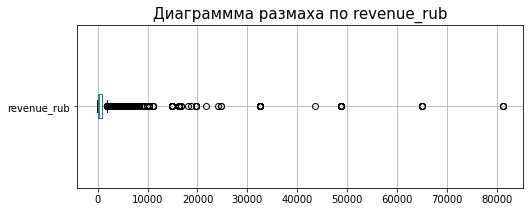

In [24]:
# Посмотрим распредение данных в столбце revenue_rub
df.boxplot(column='revenue_rub', vert=False, grid=True, figsize=(8, 3))
plt.title('Диаграммма размаха по revenue_rub', size=15)

Заметим, что в данных присутствует большое количество выбросов, из-за которых возникают сложности с оценкой распределения данных, отфильтруем значения по 99 процентилю.

Text(0.5, 1.0, 'Диаграммма размаха по revenue_rub')

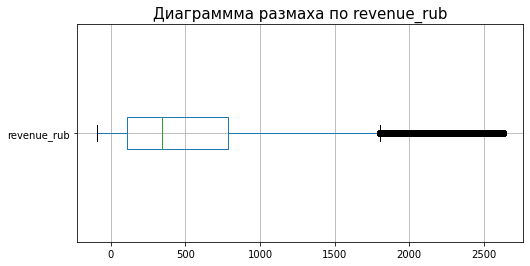

In [25]:
# Построим диаграмму с фильтром по 99 процентилю 
df[df['revenue_rub'] < df['revenue_rub'].quantile(0.99)].boxplot(column='revenue_rub', vert=False, grid=True, figsize=(8, 4))
plt.title('Диаграммма размаха по revenue_rub', size=15)

В данных присутствуют отрицательные значения, вероятно они связаны с возвратом билетов, оценим кол-во таких записей

In [26]:
print(f'''абсолюьное значение: {df[df['revenue_rub'] <= 0]['revenue_rub'].count()}
относительное значение: {round(df[df['revenue_rub'] <= 0]['revenue_rub'].count() / df.shape[0], 2)}''')

абсолюьное значение: 5907
относительное значение: 0.02


In [27]:
# Удалим эти значения 
df = df[df['revenue_rub'] > 0]

Text(0.5, 0, 'revenue_rub')

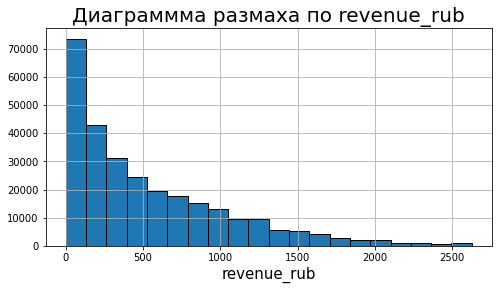

In [28]:
# Построим гстограмму с фильтром по 99 процентилю 
df[df['revenue_rub'] < df['revenue_rub'].quantile(0.99)].hist(column='revenue_rub', bins=20, grid=True, figsize=(8, 4), 
                                                             edgecolor='k')
plt.title('Диаграммма размаха по revenue_rub', size=20)
plt.xlabel('revenue_rub', size=15)

Заметим, что распределение имеет ярко выраженный правй хвост, что говорит о положительной ассиметрии. большинство значений лежат в диапазоне от 0 до 500

Text(0.5, 1.0, 'Диаграммма размаха по tickets_count')

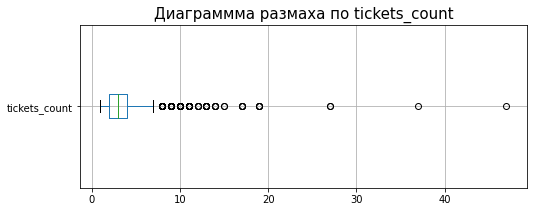

In [29]:
# Посмотрим распредение данных в столбце tickets_count
df.boxplot(column='tickets_count', vert=False, grid=True, figsize=(8, 3))
plt.title('Диаграммма размаха по tickets_count', size=15)

Заметим что в данных присутствует большое количество выбросов, это мешает анализу разброса.
Рассмотрим распределеине без учета выбросов

Text(0.5, 1.0, 'Диаграммма размаха по tickets_count')

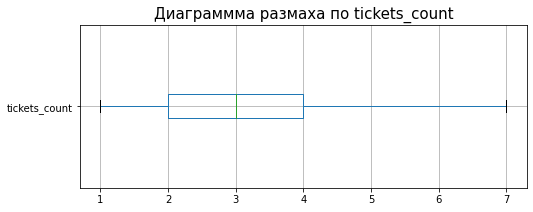

In [30]:
# Посмотрим распредение данных в столбце tickets_count без учета выбросов 
df.boxplot(column='tickets_count', vert=False, grid=True, figsize=(8, 3), showfliers=False)
plt.title('Диаграммма размаха по tickets_count', size=15)

Заметим, что в большинстве заказов покупается от 2 до 4 билетов, посмотрим на распределение значений от 1 до 7

Text(0.5, 0, 'tickets_count')

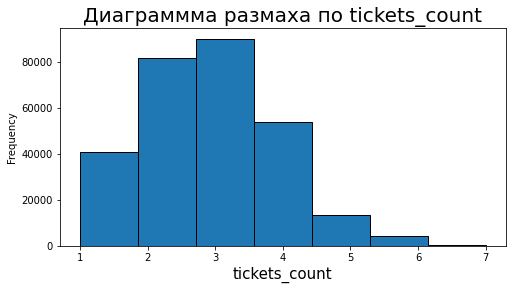

In [31]:
# Построим гистограмму для tickets_count
df[df['tickets_count'] <= 7]['tickets_count'].plot(kind='hist', figsize=(8, 4), edgecolor='k', bins=7)
plt.title('Диаграммма размаха по tickets_count', size=20)
plt.xlabel('tickets_count', size=15)

На гистограмме видно, что практически во всех заказах от 1 до 6 билетов

In [32]:
# Изучим значения в days_since_prev
df[df['days_since_prev'] > -1]['days_since_prev'].describe() # Отберем данные без учета первых заказов

count    263119.000000
mean          3.249925
std          11.412753
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max         148.000000
Name: days_since_prev, dtype: float64

Заметим очень высокий максимум, для среднего 3.2 и стандартного отклонения 11.3 
Очевидно в данных есть положительные выбросы.

<AxesSubplot:>

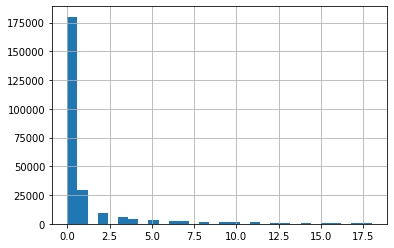

In [33]:
# визуализируем данные из days_since_prev, отсортировав по 90му процентилю
df[df['days_since_prev'] <= df['days_since_prev'].quantile(0.95)]['days_since_prev'].hist(bins=30)

<div class="alert alert-block alert-warning">📝
    

__Комментарий от ревьюера №1__

По 90 перцентилю кажется немного многовато, обычно для ML моделей срезают по 95

Большинство повторных заказов были сделаны в тот же день, что и предыдущий, другая большая часть заказов была сделана через день.

##### Промежуточный вывод

- Мы создали новый столбец `revenue_rub`, содержащий информацию о цене заказах в рублях 

- Преобразовали типы данных в столбцах:
  
    - `device_type_canonical` : `object` $\rightarrow$ `category` 
     
    - `currency_code` : `object` $\rightarrow$ `category`
    
    - `tickets_count` : `int64` $\rightarrow$ `int8`
    
    - `days_since_prev` : `float64` $\rightarrow$ `int32`
  
  
- Изучили значения в категориальных столбцах:

    - `device_type_canonical`: mobile, desctop
    
    - `currency_code`: rub, kzt
    
    - `event_type_main`: театр, выставки, другое, стендап, концерты, спорт, ёлки


- Количество уникальных значений в столбцах с названиями:

    - `service_name`: 36
    
    - `region_name`: 81
    
    - `city_name`: 352
    
   
- Проверили распредление численных данных и наличие в них выбросов:

    - В столбце `revenue_rub` присутствует большое количество положительных выбросов. Большинство значений лежит в промежутке от 0 до 2000, однако максимальное значение превышает 80 тыс.
    
    - В столбце `tickets_count` также присутствуют выбросы. Большинство заказов содержат 1-6 билетов, однако максимальное значение превышает 50
    
    - В столбце `days_since_prev` большинство заказов были сделаны в тот же день что и предыдущий, а верхний квартиль равен единице, однако максимальное значение равное 148 свидетельствует  сильном правом хвосте.
    

<div class="alert alert-block alert-danger">✍
    

__Комментарий от ревьюера №1__

В задании это не указывается, но по умолчанию важным шагом предварительного анализа и предобработки является проверка на наличие дубликатов, как полных, так и неполных (например, если заказ пользователя задублировался в системе, был создан в нескольких экземплярах с разным `id` и временем заказа). Чтобы не искажать статистические расчеты, от таких наблюдений тоже важно избавляться.    
    
    

    
---
    
Также стоит обратить внимание на наличие отрицательных значений в показателе выручки. Вероятно, они связаны с возвратами билетов. Такие записи лучше исключить из анализа, чтобы не исказить статистику по количеству и сумме реальных покупок пользователей. Перед удалением рекомендуется оценить долю этих строк в выборке, чтобы убедиться, что потери данных не окажут существенного влияния на результаты.
    
    
    

<div class="alert alert-info"> <b>Комментарии студента:</b>У вас, как я понял сверху было похожее замечеание по дубликатам, над ним провел поиск явных и неявных дубликатов, но как выявить дубликаты если у них разные id и время заказа не пойму, по-моему похожих заданий не было</div>

---

### 3. Создание профиля пользователя

В будущем отдел маркетинга планирует создать модель для прогнозирования возврата пользователей. Поэтому сейчас они просят вас построить агрегированные признаки, описывающие поведение и профиль каждого пользователя.

---

**Задача 3.1.** Постройте профиль пользователя — для каждого пользователя найдите:

- дату первого и последнего заказа;
- устройство, с которого был сделан первый заказ;
- регион, в котором был сделан первый заказ;
- билетного партнёра, к которому обращались при первом заказе;
- жанр первого посещённого мероприятия (используйте поле `event_type_main`);
- общее количество заказов;
- средняя выручка с одного заказа в рублях;
- среднее количество билетов в заказе;
- среднее время между заказами.

После этого добавьте два бинарных признака:

- `is_two` — совершил ли пользователь 2 и более заказа;
- `is_five` — совершил ли пользователь 5 и более заказов.

**Рекомендация:** перед тем как строить профиль, отсортируйте данные по времени совершения заказа.

---


In [35]:
user_profiles = (df
          # В начале сортируем данные по дате совершения заказа, что найти первые признаки:
          .sort_values(by='created_ts_msk')
          # Затем группируем по номеру пользователя и агрегируем данные:
          .groupby('user_id')
          .agg(
              # Находим первую и последнюю даты заказа:
              first_order_dt=('created_dt_msk','min'),
              last_order_dt=('created_dt_msk','max'),
              # Находим устройства, регион, название билетного партнера и тип мероприятия первого заказа:
              first_device=('device_type_canonical','first'),
              first_region_name=('region_name','first'),
              first_service_name=('service_name','first'),
              first_event_type=('event_type_main','first'),
              # Подсчитваем количество заказов:
              total_orders=('order_id','nunique'),
              # Считаем статистику по заказам: средняя стоимость заказа, среднее количество билетов:
              avg_revenue_rub=('revenue_rub','mean'),
              avg_tickets_count=('tickets_count','mean'),
              # Считаем среднее количество дней между покупками:
              avg_days_since_prev=('days_since_prev','mean')
          )
          # Создаем два признака: совершил ли пользователь 2 / 5 и более заказов:
          .assign(
              is_two = lambda x: x['total_orders'] >= 2,
              is_five = lambda x: x['total_orders'] >= 5
          )
          .reset_index()
  )
user_profiles.head()  

,user_id,first_order_dt,last_order_dt,first_device,first_region_name,first_service_name,first_event_type,total_orders,avg_revenue_rub,avg_tickets_count,avg_days_since_prev,is_two,is_five
0,0002849b70a3ce2,2024-08-20,2024-08-20,mobile,Каменевский регион,Край билетов,театр,1,1521.940000,4.000000,NaN,False,False
1,0005ca5e93f2cf4,2024-07-23,2024-10-06,mobile,Каменевский регион,Мой билет,выставки,2,774.010000,3.000000,75.0,True,False
2,000898990054619,2024-07-13,2024-10-23,mobile,Североярская область,Лови билет!,другое,3,767.213333,2.666667,51.0,True,False
3,00096d1f542ab2b,2024-08-15,2024-08-15,desktop,Каменевский регион,Край билетов,театр,1,917.830000,4.000000,NaN,False,False
4,000a55a418c128c,2024-09-29,2024-10-15,mobile,Поленовский край,Лучшие билеты,театр,2,61.310000,1.500000,16.0,True,False


<div class="alert alert-block alert-danger">✍
    

__Комментарий от ревьюера №1__

    
Важный момент: берешь в user_first_order всех, у кого days_since_prev == -1. Но -1 просто заглушка, то у тебя в профиле окажутся некорректные данные о первом заказе пользователей.

Перед тем, как строить профиль, тебе нужно не учи ывать эти заглушки. Иначе, все твои дальнейшие выводы будут неверными! Попробуй заменить -1 на NaN, или проще не заменять эти пропуски в ПО
    
---
    
Также перед агрегацией сначала сортируем по пользователю и дате, чтобы первый заказ был первым

<div class="alert alert-block alert-danger">✍
    

__Комментарий от ревьюера №1__
    
    
Твой способ определения значений категориальных характеристик первого заказа не надежен. Если у пользователя было несколько заказов в первый день, присоединение значений по дате приведет к дублированию записей о пользователе.
    
В данном случае необходимо группировать и использовать метод агрегации `first`, он берет значение первой записи. Как раз ввиду его использования и следовало отсортировать заказы по времени.
    
Обрати внимание, что с учетом данной правки могут потребоваться и корректировки в шагах ниже.
    
</div>    

<div class="alert alert-block alert-warning">📝
    

__Комментарий от ревьюера №1__
    
* Также есть довольно удобный метод [assign](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.assign.html), позволяющий дополнять таблицу новыми рассчитанными столбцами.
    
    Тогда создание всего профиля можно будет записать красивым и удобным по структуре кодом.

    <details> <summary> <span style='color:blue' > Развернуть подробнее. </span> </summary>

    ```python
    profiles = (df
            # В начале сортируем данные по дате совершения заказа, что найти первые признаки:
            .sort_values(by='order_ts')
            # Затем группируем по номеру пользователя и агрегируем данные:
            .groupby('user_id')
            .agg(
                # Находим первую и последнюю даты заказа:
                first_order_dt=('order_dt','min'),
                last_order_dt=('order_dt','max'),
                # Находим устройства, регион, название билетного партнера и тип мероприятия первого заказа:
                first_device=('device_type_canonical','first'),
                first_region_name=('region_name','first'),
                first_service_name=('service_name','first'),
                first_event_type=('event_type_main','first'),
                # Подсчитваем количество заказов:
                total_orders=('order_id','nunique'),
                # Считаем статистику по заказам: средняя стоимость заказа, среднее количество билетов:
                avg_revenue_rub=('revenue_rub','mean'),
                avg_tickets_count=('tickets_count','mean'),
                # Считаем среднее количество дней между покупками:
                avg_days_since_prev=('days_since_prev','mean')
            )
            # Создаем два признака: совершил ли пользователь 2 / 5 и более заказов:
            .assign(
                is_two = lambda x: x['total_orders'] >= 2,
                is_five = lambda x: x['total_orders'] >= 5
            )
            .reset_index()
    )
    ```
    </details>

    

    
</div>

<div class="alert alert-info"> <b>Комментарии студента:</b>Спасибо за ваш способ, вижу что намного красивее и удобнее, замену на индикаторы убрал</div>

---

**Задача 3.2.** Прежде чем проводить исследовательский анализ данных и делать выводы, важно понять, с какими данными вы работаете: насколько они репрезентативны и нет ли в них аномалий.

Используя данные о профилях пользователей, рассчитайте:

- общее число пользователей в выборке;
- среднюю выручку с одного заказа;
- долю пользователей, совершивших 2 и более заказа;
- долю пользователей, совершивших 5 и более заказов.

Также изучите статистические показатели:

- по общему числу заказов;
- по среднему числу билетов в заказе;
- по среднему количеству дней между покупками.

По результатам оцените данные: достаточно ли их по объёму, есть ли аномальные значения в данных о количестве заказов и среднем количестве билетов?

Если вы найдёте аномальные значения, опишите их и примите обоснованное решение о том, как с ними поступить:

- Оставить и учитывать их при анализе?
- Отфильтровать данные по какому-то значению, например, по 95-му или 99-му перцентилю?

Если вы проведёте фильтрацию, то вычислите объём отфильтрованных данных и выведите статистические показатели по обновлённому датасету.

In [36]:
# Пользуясь анкетой рассчитаем показатели user_profile

sum_revenue = sum(user_profiles['total_orders'] * user_profiles['avg_revenue_rub'])


print(f'''Общее число пользователей: {user_profiles.shape[0]}
Средяя выручка с одного заказа: {round(sum_revenue / sum(user_profiles['total_orders']), 2)}
Доля пользователей, совершивших 2 и более заказа: {round(user_profiles['is_two'].mean(), 2)}
Доля пользователей, совершивших 5 и более заказов: {round(user_profiles['is_five'].mean(), 2)}''')

Общее число пользователей: 21779
Средяя выручка с одного заказа: 567.1
Доля пользователей, совершивших 2 и более заказа: 0.62
Доля пользователей, совершивших 5 и более заказов: 0.29


In [37]:
# Изучим статистические показатели 

user_profiles[['total_orders', 'avg_tickets_count', 'avg_days_since_prev']].describe()

,total_orders,avg_tickets_count,avg_days_since_prev
count,21779.000000,21779.000000,13496.000000
mean,13.072409,2.758935,15.875495
std,120.569323,0.921939,22.311092
min,1.000000,1.000000,0.000000
25%,1.000000,2.000000,1.000000
50%,2.000000,2.772727,8.057190
75%,5.000000,3.142857,20.500000
max,10057.000000,12.000000,148.000000


- В столбце `cnt_orders` присутствуют аномально выское значения, при верхнем квартиле равном 5, стандартное отклонение равно 122, а максимум 10251. Отфильтруем значения по 95 процентилю

- В столбце `tickets_mean` нет значений, похожий на аномальные.

- В столбце `days_mean` высокий максимум, но он не нуждается в фильрации и обусловлен 

In [38]:
user_profiles = user_profiles[user_profiles['total_orders'] <= user_profiles['total_orders'].quantile(0.95)]
user_profiles.describe()

,total_orders,avg_revenue_rub,avg_tickets_count,avg_days_since_prev
count,20700.000000,20700.000000,20700.000000,12417.000000
mean,4.050773,583.392607,2.759307,17.067784
std,5.105466,569.889503,0.943424,22.871873
min,1.000000,0.070000,1.000000,0.000000
25%,1.000000,212.285000,2.000000,1.000000
50%,2.000000,474.754167,2.789474,9.500000
75%,5.000000,807.261250,3.200000,22.250000
max,31.000000,16738.696667,12.000000,148.000000


После фильтрации по 95му процентилю из 21779 значений осталось 20700, максимум с 10057 снизился до 31, а стандартное отклонение со 120.5 до 5.1

<div class="alert alert-block alert-danger">✍
    

__Комментарий от ревьюера №1__

days_mean имеет отрицательное значение. Это результат реализации профиля

---

### 4. Исследовательский анализ данных

Следующий этап — исследование признаков, влияющих на возврат пользователей, то есть на совершение повторного заказа. Для этого используйте профили пользователей.



#### 4.1. Исследование признаков первого заказа и их связи с возвращением на платформу

Исследуйте признаки, описывающие первый заказ пользователя, и выясните, влияют ли они на вероятность возвращения пользователя.

---

**Задача 4.1.1.** Изучите распределение пользователей по признакам.

- Сгруппируйте пользователей:
    - по типу их первого мероприятия;
    - по типу устройства, с которого совершена первая покупка;
    - по региону проведения мероприятия из первого заказа;
    - по билетному оператору, продавшему билеты на первый заказ.
- Подсчитайте общее количество пользователей в каждом сегменте и их долю в разрезе каждого признака. Сегмент — это группа пользователей, объединённых определённым признаком, то есть объединённые принадлежностью к категории. Например, все клиенты, сделавшие первый заказ с мобильного телефона, — это сегмент.
- Ответьте на вопрос: равномерно ли распределены пользователи по сегментам или есть выраженные «точки входа» — сегменты с наибольшим числом пользователей?

---


Text(0, 0.5, 'кол-во пользователей')

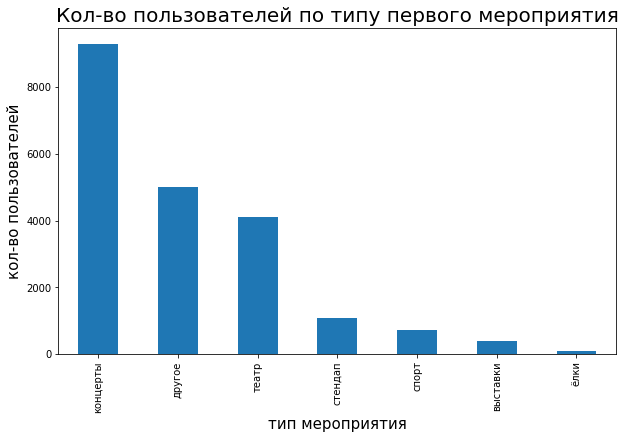

In [39]:
# Сгруппируем пользователей по типу мероприятия
group_event_type = user_profiles.groupby('first_event_type')

# Посмотрим кол-во пользователей по сегментам а так же отобразим их долю припопомщи визуализации
group_event_type['user_id'].count().sort_values(ascending=False).plot(kind='bar', figsize=(10, 6))
plt.title('Кол-во пользователей по типу первого мероприятия', size=20)
plt.xlabel('тип мероприятия', size=15)
plt.ylabel('кол-во пользователей', size=15)

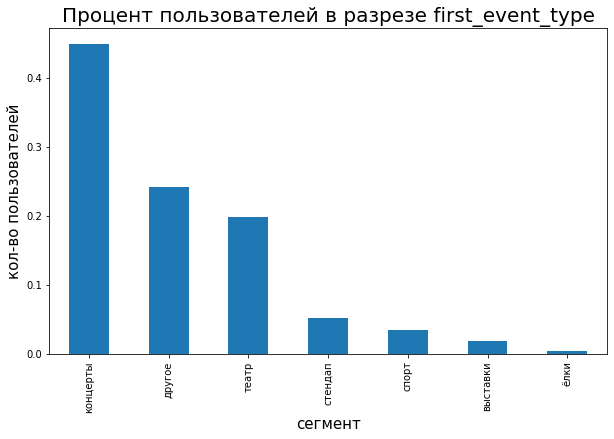

In [56]:
# Относительные значения 
# Напишем функцию для поиска относительных значений

def perc(col, index=None):
    group = user_profiles.groupby(col)['user_id'].count() / user_profiles.shape[0]
    group.sort_values(ascending=False).iloc[:index].plot(kind='bar', figsize=(10, 6))
    plt.title(f'Процент пользователей в разрезе {col}', size=20)
    plt.xlabel('сегмент', size=15)
    plt.ylabel('кол-во пользователей', size=15)
    
perc('first_event_type')

Больше всего пользователей впервые посетили мероприятие, одного из следующих типов: 
- Концерт - более 8 тыс.
- Другое - около 5 тыс.
- театр - около 4 тыс.

Text(0, 0.5, 'кол-во пользователей')

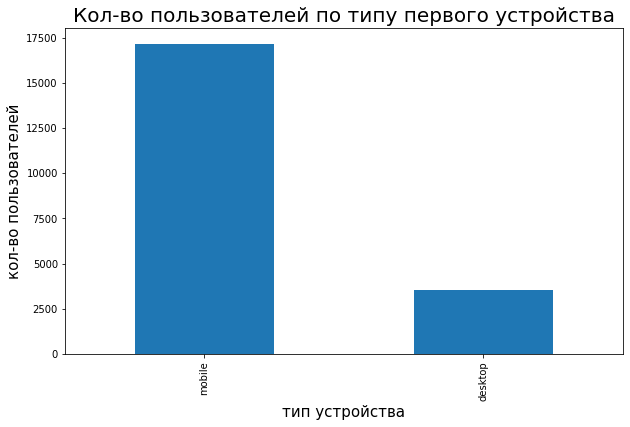

In [42]:
# Сгруппируем пользователей по типу устройства 
group_device = user_profiles.groupby('first_device')

# Посмотрим кол-во пользователей по сегментам а так же отобразим их долю припопомщи визуализации
group_device['user_id'].count().sort_values(ascending=False).plot(kind='bar', figsize=(10, 6))
plt.title('Кол-во пользователей по типу первого устройства', size=20)
plt.xlabel('тип устройства', size=15)
plt.ylabel('кол-во пользователей', size=15)

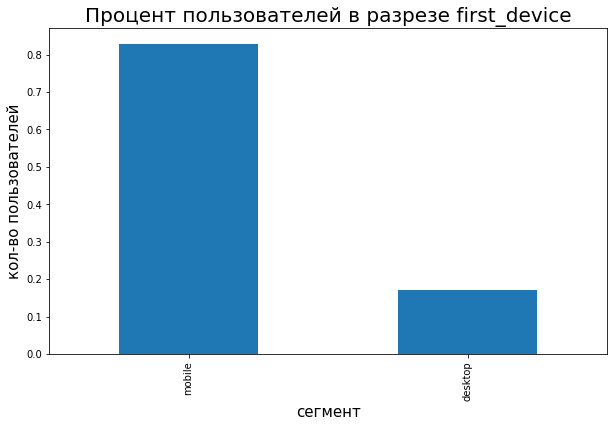

In [53]:
# Относительные значения 
perc('first_device')

Большинство первых заказов сделаны с мобильных телефонов ~17 тыс. (80%)

Text(0, 0.5, 'кол-во пользователей')

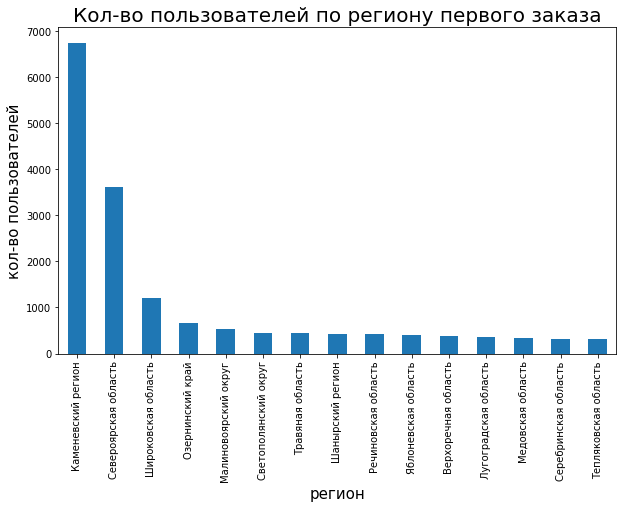

In [43]:
# Сгруппируем пользователей по региону 
group_region = user_profiles.groupby('first_region_name')

# Посмотрим кол-во пользователей по сегментам а так же отобразим их долю припопомщи визуализации
group_region['user_id'].count().sort_values(ascending=False).iloc[:15].plot(kind='bar', figsize=(10, 6))
plt.title('Кол-во пользователей по региону первого заказа', size=20)
plt.xlabel('регион', size=15)
plt.ylabel('кол-во пользователей', size=15)

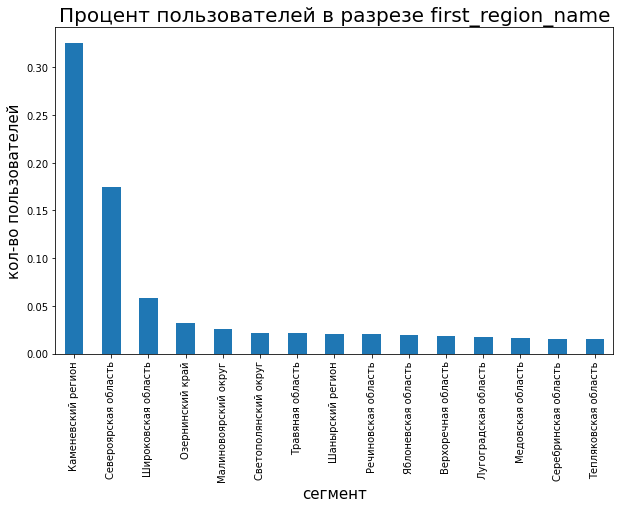

In [57]:
# Относительные значения 
perc('first_region_name', 15)

Большинство первых заказов сделаны с регионов:
- Каменевский регион - более 6.5 тыс. ~35%
- Североярская область - около 3.5 тыс. ~17%
- Широковская область - более 1 тыс. ~6%

Text(0, 0.5, 'кол-во пользователей')

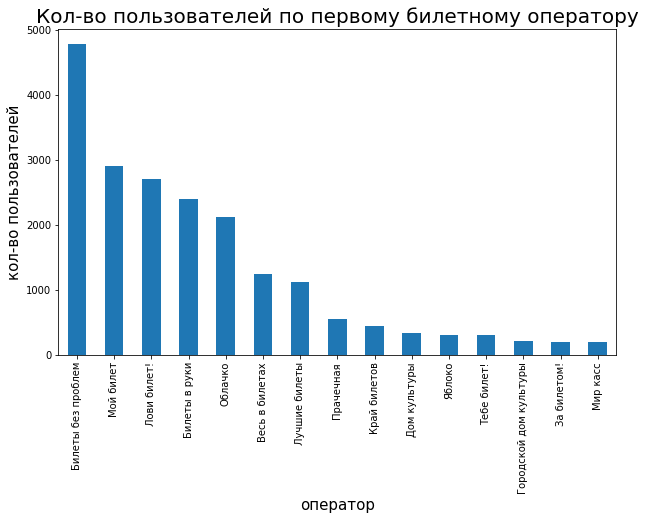

In [45]:
# Сгруппируем пользователей по билетному оператору 
group_service = user_profiles.groupby('first_service_name')

# Посмотрим кол-во пользователей по сегментам а так же отобразим их долю припопомщи визуализации
group_service['user_id'].count().sort_values(ascending=False).iloc[:15].plot(kind='bar', figsize=(10, 6))
plt.title('Кол-во пользователей по первому билетному оператору', size=20)
plt.xlabel('оператор', size=15)
plt.ylabel('кол-во пользователей', size=15)

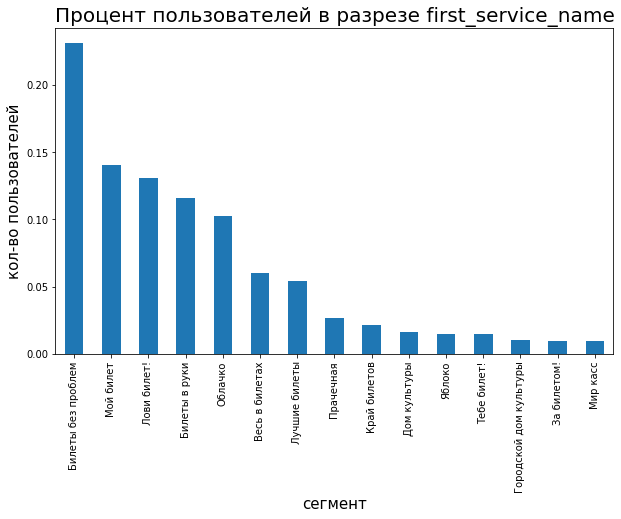

In [58]:
# Относительные значения 
perc('first_service_name', 15)

Большинство первых заказов сделаны у операторов:

- Билеты без проблем - более 4 тыс. более 20%
- Мой билет - около 3 тыс.
- Лови билет! - около 2.5 тыс.
- Билеты в руки - около 2.5 тыс.
- Облачко - около 2 тыс.
- Весь в билетах - более 1 тыс.
- Лучшие билеты - более 1 тыс.

Во всех случаях пользователи распределены не равномерно, по каждому признаку видны "точки входа"

<div class="alert alert-block alert-danger">✍
    

__Комментарий от ревьюера №1__

    
В этом шаге также предлагаю рассмотреть не только абсолютные значения, но и относительные (поскольку написано `Подсчитайте общее количество пользователей в каждом сегменте и их долю в разрезе каждого признака`)

---

**Задача 4.1.2.** Проанализируйте возвраты пользователей:

- Для каждого сегмента вычислите долю пользователей, совершивших два и более заказа.
- Визуализируйте результат подходящим графиком. Если сегментов слишком много, то поместите на график только 10 сегментов с наибольшим количеством пользователей. Такое возможно с сегментами по региону и по билетному оператору.
- Ответьте на вопросы:
    - Какие сегменты пользователей чаще возвращаются на Яндекс Афишу?
    - Наблюдаются ли успешные «точки входа» — такие сегменты, в которых пользователи чаще совершают повторный заказ, чем в среднем по выборке?

При интерпретации результатов учитывайте размер сегментов: если в сегменте мало пользователей (например, десятки), то доли могут быть нестабильными и недостоверными, то есть показывать широкую вариацию значений.

---


In [63]:
# Напишем функцию для подсчета конверсии и ее визуализации
def conv(value, m=None):
    users = user_profiles.groupby(value)['user_id'].count() 
    users_is_two = user_profiles[user_profiles['is_two']==1].groupby(value)['user_id'].count()
    convers = users_is_two / users * 100
    return convers.sort_values(ascending=False).iloc[:m].plot(kind='bar', figsize=(8, 4))

Text(0, 0.5, 'Конверсия, %')

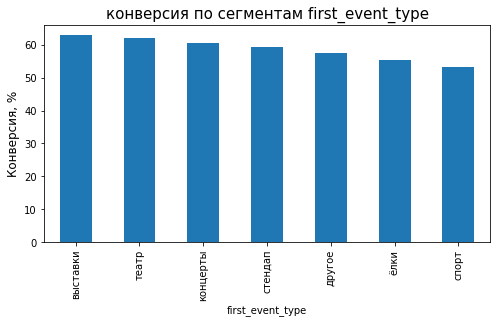

In [64]:
# строим визуализации по сегментам столбца
conv('first_event_type')
plt.title('конверсия по сегментам first_event_type', size=15)
plt.ylabel('Конверсия, %', size=12)

Text(0, 0.5, 'Конверсия, %')

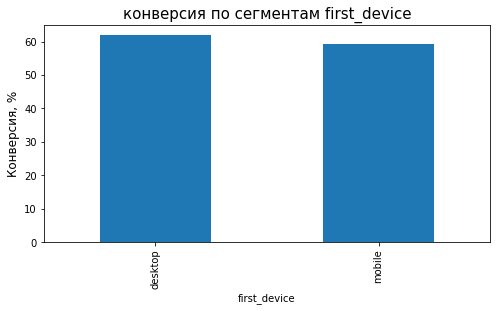

In [66]:
# строим визуализации по сегментам столбца
conv('first_device')
plt.title('конверсия по сегментам first_device', size=15)
plt.ylabel('Конверсия, %', size=12)

Text(0, 0.5, 'Конверсия, %')

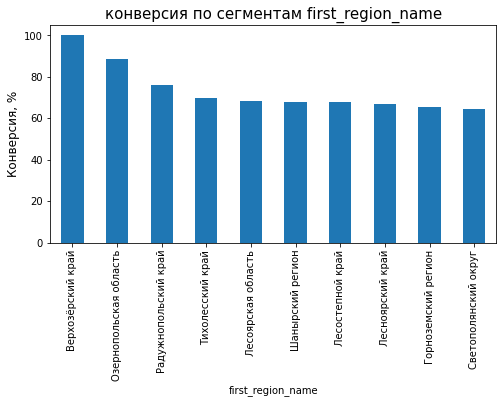

In [67]:
# строим визуализации по сегментам столбца
conv('first_region_name', 10)
plt.title('конверсия по сегментам first_region_name', size=15)
plt.ylabel('Конверсия, %', size=12)

Text(0, 0.5, 'Конверсия, %')

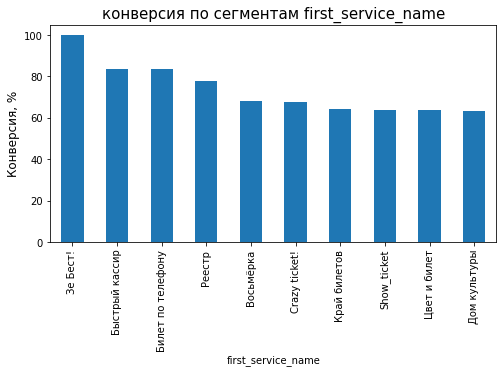

In [68]:
# строим визуализации по сегментам столбца
conv('first_service_name', 10)
plt.title('конверсия по сегментам first_service_name', size=15)
plt.ylabel('Конверсия, %', size=12)

По графикам видно, что коверсия не сильно зависит от сегментации, однако среди регионов и сервисов есть сегменты с конверсией, стремящейся к 100%: сервис Зе Бест! и Верхозерский край. Это может быть связано с малым числом пользователей по сегменту в целом.

<div class="alert alert-block alert-warning">📝
    

__Комментарий от ревьюера №1__

В реальной практике, заказчики (менеджеры) любят получать точные значения (например конверсия по девайсу 55 или 57%)

---

**Задача 4.1.3.** Опираясь на выводы из задач выше, проверьте продуктовые гипотезы:

- **Гипотеза 1.** Тип мероприятия влияет на вероятность возврата на Яндекс Афишу: пользователи, которые совершили первый заказ на спортивные мероприятия, совершают повторный заказ чаще, чем пользователи, оформившие свой первый заказ на концерты.
- **Гипотеза 2.** В регионах, где больше всего пользователей посещают мероприятия, выше доля повторных заказов, чем в менее активных регионах.

---

Гипотеза 1
Некорректно сравнивать показатели тк на концерт приходило примерно в 9 раз больше пользователей чем на спортивные мероприятия, однако если смотреть на конверсию, то в случае концертов она больше, чем в случае спортивных мероприятий, таким образом мы можем говорить о том, что первая гипотеза не имеет обоснованного подтверждения

Гипотеза 2
Большинство первых заказов сделаны с регионов: Каменевский регион, Североярская область, Широковская область. Эти регионы не входят в топ 10 по величине конверсии пользователей в пользователей, совершивших 2 и более покупки, таким образом вторая гипотеза не подтвердилась 

<div class="alert alert-block alert-success">✔️
    

__Комментарий от ревьюера №1__

По второй гипотезе можно сопоставить объем выборки с полученными результатом  

---

#### 4.2. Исследование поведения пользователей через показатели выручки и состава заказа

Изучите количественные характеристики заказов пользователей, чтобы узнать среднюю выручку сервиса с заказа и количество билетов, которое пользователи обычно покупают.

Эти метрики важны не только для оценки выручки, но и для оценки вовлечённости пользователей. Возможно, пользователи с более крупными и дорогими заказами более заинтересованы в сервисе и поэтому чаще возвращаются.

---

**Задача 4.2.1.** Проследите связь между средней выручкой сервиса с заказа и повторными заказами.

- Постройте сравнительные гистограммы распределения средней выручки с билета (`avg_revenue_rub`):
    - для пользователей, совершивших один заказ;
    - для вернувшихся пользователей, совершивших 2 и более заказа.
- Ответьте на вопросы:
    - В каких диапазонах средней выручки концентрируются пользователи из каждой группы?
    - Есть ли различия между группами?

Текст на сером фоне:
    
**Рекомендация:**

1. Используйте одинаковые интервалы (`bins`) и прозрачность (`alpha`), чтобы визуально сопоставить распределения.
2. Задайте параметру `density` значение `True`, чтобы сравнивать форму распределений, даже если число пользователей в группах отличается.

---


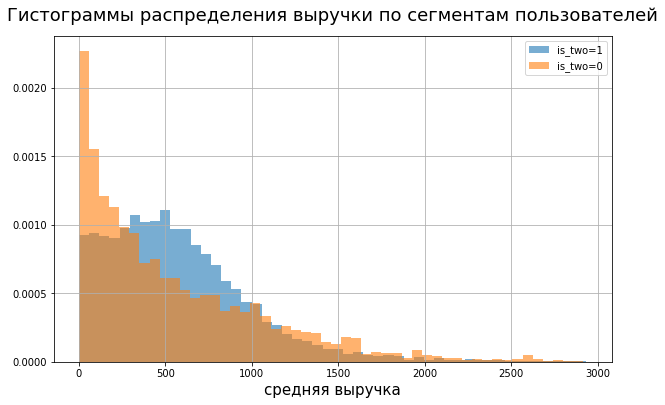

In [70]:
plt.figure(figsize=(10, 6))
plt.hist(user_profiles[user_profiles['is_two']==1]['avg_revenue_rub'][user_profiles['avg_revenue_rub'] < 3000], 
         bins=50, alpha=0.6, density=True, label='is_two=1')
plt.hist(user_profiles[user_profiles['is_two']==0]['avg_revenue_rub'][user_profiles['avg_revenue_rub'] < 3000], 
         bins=50, alpha=0.6, density=True, label='is_two=0')
# часть выбросов мы урезали параметром user_profile['mean_revenue_rub'] < 3000 для более наглядного отображения
plt.title('Гистограммы распределения выручки по сегментам пользователей', size=18, pad=15)
plt.xlabel('средняя выручка', size=15)
plt.grid()
plt.legend()
plt.show()

Между группами присутствует различие. Среди пользователей, не совершивших повторный заказ наблюдается резкий скачок кол-ва значений в интервале от 0 до ~200, среди тех, кто совершил повторыный заказ, данные распределены более равномерно, наблюдается большее кол-во значений в диапазоне от 200 до 1000

---

**Задача 4.2.2.** Сравните распределение по средней выручке с заказа в двух группах пользователей:

- совершившие 2–4 заказа;
- совершившие 5 и более заказов.

Ответьте на вопрос: есть ли различия по значению средней выручки с заказа между пользователями этих двух групп?

---


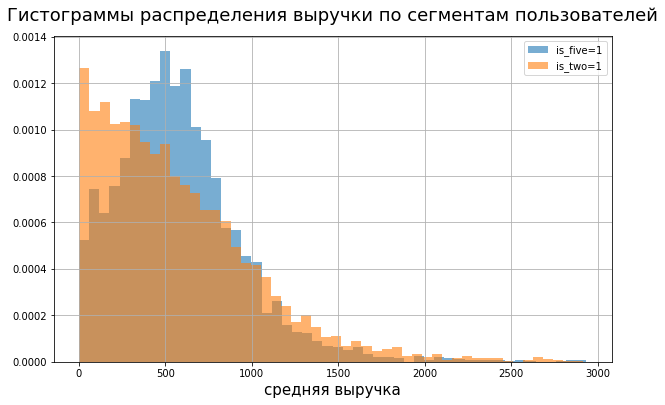

In [71]:
plt.figure(figsize=(10, 6))
plt.hist(user_profiles[user_profiles['is_five']==1]['avg_revenue_rub'][user_profiles['avg_revenue_rub'] < 3000], 
         bins=50, alpha=0.6, density=True, label='is_five=1')
plt.hist(user_profiles[(user_profiles['is_five']==0)
                     & user_profiles['is_two']==1]['avg_revenue_rub'][user_profiles['avg_revenue_rub'] < 3000], 
         bins=50, alpha=0.6, density=True, label='is_two=1')
# часть выбросов мы урезали параметром user_profile['avg_revenue_rub'] < 3000 для более наглядного отображения
plt.title('Гистограммы распределения выручки по сегментам пользователей', size=18, pad=15)
plt.xlabel('средняя выручка', size=15)
plt.grid()
plt.legend()
plt.show()

Среди представленных групп есть различия по средней выручке: разница аналогична сравнения групп по признаку `is_two`:
Распределения значений is_five=1 ближе к нормальному, мода приблизительно равно 500, в случае же с is_five=0 клиентами мода находится в значениях близких к нулю

<div class="alert alert-block alert-success">✔️
    

__Комментарий от ревьюера №1__

    
* С этой задачей тоже справились! 
    
 
* Плюс за грамотное оформление графиков - заголовок, подписи осей, легенда, поправка на размер выборки (`density`). По выводам тоже все верно подмечено!
 
</div>
<div class="alert alert-block alert-warning">📝
    

__Комментарий от ревьюера №1__
    



    
* Чтобы удобно было сопоставлять доли пользователей по диапазонам цен, можно настроить единый размер бинов (`bins = 50` фиксирует количество бинов, но размер между сегментами будет отличаться, поскольку диапазон значений у них разный). Для этого в `bins` можно передать границы для формирования бинов с шагом: `bins = range(min_value, max_value+1, 50)`, максимальное и минимальное значения при этом определяем на всей выборке, а не отдельно для каждого сегмента.

</div>

---

**Задача 4.2.3.** Проанализируйте влияние среднего количества билетов в заказе на вероятность повторной покупки.

- Изучите распределение пользователей по среднему количеству билетов в заказе (`avg_tickets_count`) и опишите основные наблюдения.
- Разделите пользователей на несколько сегментов по среднему количеству билетов в заказе:
    - от 1 до 2 билетов;
    - от 2 до 3 билетов;
    - от 3 до 5 билетов;
    - от 5 и более билетов.
- Для каждого сегмента подсчитайте общее число пользователей и долю пользователей, совершивших повторные заказы.
- Ответьте на вопросы:
    - Как распределены пользователи по сегментам — равномерно или сконцентрировано?
    - Есть ли сегменты с аномально высокой или низкой долей повторных покупок?

---

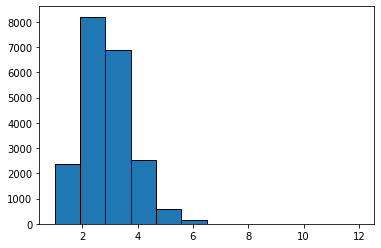

In [72]:
# Изучим распределение пользователей по среднему количеству билетов в заказе
plt.hist(user_profiles['avg_tickets_count'], bins=12, edgecolor='k')
plt.show()

Среднее кол-во билетов имеет нормальное распределение, большинство значений лежат в диапазоне 2-4

In [76]:
# Разделим пользователей на сегменты 
bins = [1, 2, 3, 5, user_profiles['avg_tickets_count'].max()+1]
labels = ['1-2 билета', '2-3 билета', '3-5 билетов', '5+ билетов']
user_profiles['tickets_category'] = pd.cut(user_profiles['avg_tickets_count'], bins=bins, labels=labels, include_lowest=True)

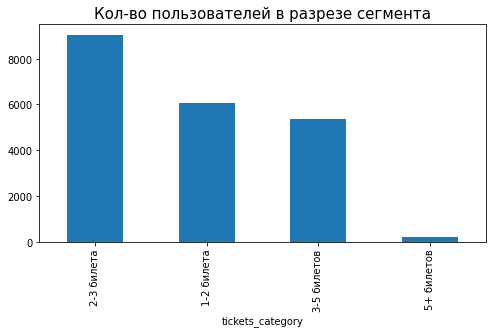

In [77]:
# общее число пользователей по сегментам 
user_profiles.groupby('tickets_category')['user_id'].count().sort_values(ascending=False).plot(kind='bar', figsize=(8, 4))
plt.title('Кол-во пользователей в разрезе сегмента', size=15)
plt.show()

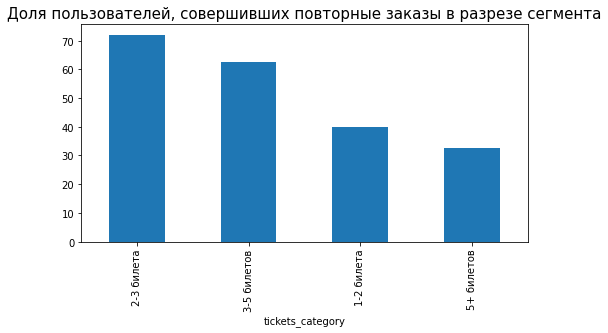

In [78]:
# Доля пользователей, совершивших повторные заказы в разрезе сегмента
conv('tickets_category') # Воспользуемся ранее написанной функцией
plt.title('Доля пользователей, совершивших повторные заказы в разрезе сегмента', size=15)
plt.show()

Пользователи распределены по сегментам не равномерно, большинство пользователей в среднем покупали 2-3 билета, тех кто брал 5 и более билетов сильно меньше.

Сегменты с аномально высокой или низкой долей повторных покупок отсутствуют, все значения лежат в диапазоне 40-70%

<div class="alert alert-block alert-success">✔️
    

__Комментарий от ревьюера №1__

Можно чуть развить вывод — предположить, почему пользователи, покупающие 2–3 билета, возвращаются чаще. Например, это могут быть небольшие компании или семьи, которые чаще ходят на мероприятия вместе, а значит, лояльность у них выше. А вот пользователи с 5+ билетами, вероятно, совершают разовые групповые покупки (например, для организации или класса), поэтому возвращаются реже

---

#### 4.3. Исследование временных характеристик первого заказа и их влияния на повторные покупки

Изучите временные параметры, связанные с первым заказом пользователей:

- день недели первой покупки;
- время с момента первой покупки — лайфтайм;
- средний интервал между покупками пользователей с повторными заказами.

---

**Задача 4.3.1.** Проанализируйте, как день недели, в которой была совершена первая покупка, влияет на поведение пользователей.

- По данным даты первого заказа выделите день недели.
- Для каждого дня недели подсчитайте общее число пользователей и долю пользователей, совершивших повторные заказы. Результаты визуализируйте.
- Ответьте на вопрос: влияет ли день недели, в которую совершена первая покупка, на вероятность возврата клиента?

---


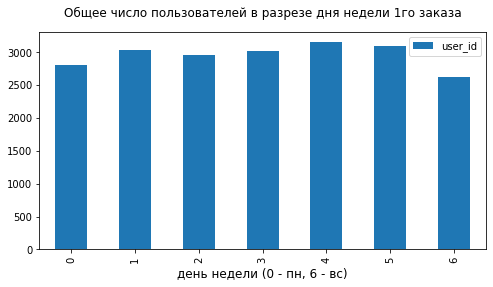

In [80]:
# Общее число пользователей в разрезе дня недели 1го заказа 
user_profiles['first_dow'] = user_profiles['first_order_dt'].dt.dayofweek
user_profiles.groupby('first_dow')['user_id'].count().reset_index().sort_values(by='first_dow').set_index('first_dow').plot(
kind='bar', figsize=(8, 4))
plt.title('Общее число пользователей в разрезе дня недели 1го заказа', pad=15)
plt.xlabel('день недели (0 - пн, 6 - вс)', size=12)
plt.show()

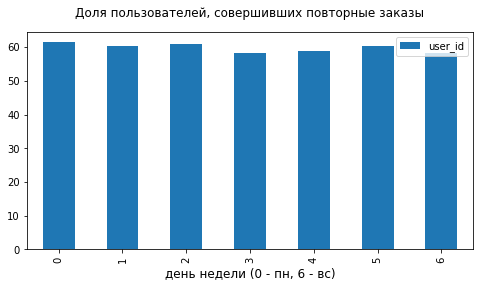

In [81]:
# Доля пользователей, совершивших повторные заказы
users = user_profiles.groupby('first_dow')['user_id'].count() 
users_is_two = user_profiles[user_profiles['is_two']==1].groupby('first_dow')['user_id'].count()
convers = users_is_two / users * 100
convers.reset_index().sort_values(by='first_dow').set_index('first_dow').plot(kind='bar', figsize=(8, 4))

plt.title('Доля пользователей, совершивших повторные заказы', pad=15)
plt.xlabel('день недели (0 - пн, 6 - вс)', size=12)
plt.show()

Основываясь на полученных данных, можем сделать вывод, что день недели не влияет на вероятность возврата клиента

<div class="alert alert-block alert-success">✔️
    

__Комментарий от ревьюера №1__

Когда планируют досуг, но возвращаемость остаётся примерно одинаковой — это говорит о том, что день недели первой покупки не влияет на лояльность, а повторное использование сервиса определяется скорее качеством опыта и интересом к мероприятиям

---

**Задача 4.3.2.** Изучите, как средний интервал между заказами влияет на удержание клиентов.

- Рассчитайте среднее время между заказами для двух групп пользователей:
    - совершившие 2–4 заказа;
    - совершившие 5 и более заказов.
- Исследуйте, как средний интервал между заказами влияет на вероятность повторного заказа, и сделайте выводы.

---


In [86]:
bins = [1, 2, 5, user_profiles['total_orders'].max()+1]
labels = ['1 заказ', '2-4 заказа', '5+ заказов']
user_profiles['order_category'] = pd.cut(user_profiles['total_orders'], bins=bins, labels=labels, include_lowest=True)

def avg_days_between(cond):
    sum_days = sum(user_profiles[cond]['avg_days_since_prev']*(user_profiles[cond]['total_orders']-1))
    count_intervals = sum(user_profiles[cond]['total_orders'])-user_profiles[cond]['user_id'].count()
    return round(sum_days / count_intervals, 2)

cond1 = user_profiles['order_category']=='2-4 заказа'
cond2 = user_profiles['order_category']=='5+ заказов'

print(f'''Среднее время между заказами пользователей, совершивших 2-4 заказа: {avg_days_between(cond1)}
Среднее время между заказами пользователей, совершивших 5 и более заказов: {avg_days_between(cond2)}''')

Среднее время между заказами пользователей, совершивших 2-4 заказа: 17.21
Среднее время между заказами пользователей, совершивших 5 и более заказов: 8.51


Text(0, 0.5, 'среднее кол-во дней между заказами')

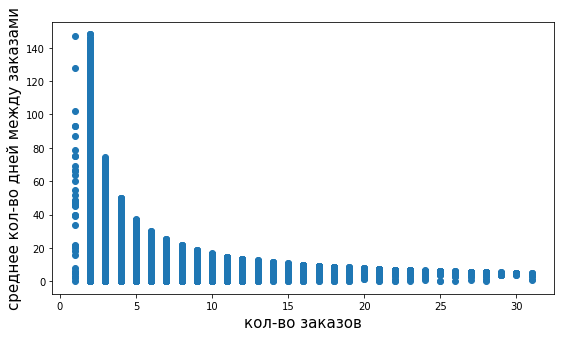

In [90]:
plt.figure(figsize=(9, 5))
plt.scatter(user_profiles['total_orders'], user_profiles['avg_days_since_prev'])
plt.xlabel('кол-во заказов', size=15)
plt.ylabel('среднее кол-во дней между заказами', size=15)

По графику можно заметить обратную корреляцию между кол-вом заказов и кол-вом дней между ними: чем больше заказов, тем меньше интервал 

---

#### 4.4. Корреляционный анализ количества покупок и признаков пользователя

Изучите, какие характеристики первого заказа и профиля пользователя могут быть связаны с числом покупок. Для этого используйте универсальный коэффициент корреляции `phi_k`, который позволяет анализировать как числовые, так и категориальные признаки.

---

**Задача 4.4.1:** Проведите корреляционный анализ:
- Рассчитайте коэффициент корреляции `phi_k` между признаками профиля пользователя и числом заказов (`total_orders`). При необходимости используйте параметр `interval_cols` для определения интервальных данных.
- Проанализируйте полученные результаты. Если полученные значения будут близки к нулю, проверьте разброс данных в `total_orders`. Такое возможно, когда в данных преобладает одно значение: в таком случае корреляционный анализ может показать отсутствие связей. Чтобы этого избежать, выделите сегменты пользователей по полю `total_orders`, а затем повторите корреляционный анализ. Выделите такие сегменты:
    - 1 заказ;
    - от 2 до 4 заказов;
    - от 5 и выше.
- Визуализируйте результат корреляции с помощью тепловой карты.
- Ответьте на вопрос: какие признаки наиболее связаны с количеством заказов?

---

In [93]:
user_profiles[user_profiles.columns.to_list()].phik_matrix()['total_orders'].sort_values(ascending=False)

interval columns not set, guessing: ['total_orders', 'avg_revenue_rub', 'avg_tickets_count', 'avg_days_since_prev', 'first_dow']


/opt/conda/lib/python3.9/site-packages/phik/data_quality.py:59: UserWarning: The number of unique values of variable user_id is large: 20700. Are you sure this is not an interval variable? Analysis for pairs of variables including user_id can be slow.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/phik/bivariate.py:255: UserWarning: Many cells: 3167100. Are interval variables set correctly?
  warnings.warn(


user_id                1.000000
total_orders           1.000000
is_five                0.986321
order_category         0.852874
is_two                 0.719750
avg_days_since_prev    0.488849
last_order_dt          0.400032
first_order_dt         0.395204
avg_tickets_count      0.331741
tickets_category       0.276762
avg_revenue_rub        0.053263
first_device           0.041838
first_service_name     0.034816
first_event_type       0.033607
first_dow              0.016742
first_region_name      0.000000
Name: total_orders, dtype: float64

In [94]:
# Посмотрим корреляцию по категориям 
matrix = user_profiles[['first_region_name', 'first_event_type', 'avg_revenue_rub', 'avg_tickets_count', 'first_order_dt', 
'last_order_dt', 'avg_days_since_prev', 'order_category',
'first_service_name', 'first_device']].phik_matrix()[['order_category']].sort_values(by='order_category', ascending=False)
matrix

interval columns not set, guessing: ['avg_revenue_rub', 'avg_tickets_count', 'avg_days_since_prev']


,order_category
order_category,1.000000
last_order_dt,0.556223
first_order_dt,0.524806
avg_days_since_prev,0.479221
avg_tickets_count,0.373157
first_region_name,0.109407
avg_revenue_rub,0.074242
first_service_name,0.066558
first_event_type,0.029832
first_device,0.013032


<AxesSubplot:>

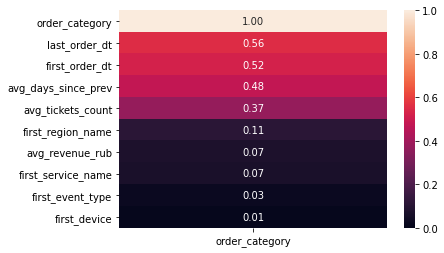

In [95]:
# строим тепловую карту
sns.heatmap(matrix, annot=True, vmin=0, vmax=1, fmt='.2f')

С кол-вом заказов наиболее сильно коррелируют атрибуты `days_mean`, `last_date` и `first_date`

<div class="alert alert-block alert-success">✔️
    

__Комментарий от ревьюера №1__
    
Расчёт абсолютно корректный.    




### 5. Общий вывод и рекомендации

В конце проекта напишите общий вывод и рекомендации: расскажите заказчику, на что нужно обратить внимание. В выводах кратко укажите:

- **Информацию о данных**, с которыми вы работали, и то, как они были подготовлены: например, расскажите о фильтрации данных, переводе тенге в рубли, фильтрации выбросов.
- **Основные результаты анализа.** Например, укажите:
    - Сколько пользователей в выборке? Как распределены пользователи по числу заказов? Какие ещё статистические показатели вы подсчитали важным во время изучения данных?
    - Какие признаки первого заказа связаны с возвратом пользователей?
    - Как связаны средняя выручка и количество билетов в заказе с вероятностью повторных покупок?
    - Какие временные характеристики влияют на удержание (день недели, интервалы между покупками)?
    - Какие характеристики первого заказа и профиля пользователя могут быть связаны с числом покупок согласно результатам корреляционного анализа?
- Дополните выводы информацией, которая покажется вам важной и интересной. Следите за общим объёмом выводов — они должны быть компактными и ёмкими.

В конце предложите заказчику рекомендации о том, как именно действовать в его ситуации. Например, укажите, на какие сегменты пользователей стоит обратить внимание в первую очередь, а какие нуждаются в дополнительных маркетинговых усилиях.

## Вывод

- В рамках исследования мы поработали с базой данных data-analyst-afisha, содержащей информацию о покупках билотов на платформе яндекс афиша. Мы составили подзапрос sql, содержащий необходимую информацию и продолжили работу с ним в jupyterhub.

- В ходе предобработки данных мы создали столбец `revenue_rub` содержащий информацию о стоимости заказа в рублях
- Также оптимизировали типы данных, изучили категориальные значения, кол-во городов, регионов и сервисов
- Создали профиль пользователя для дальнейшей работы

Основные результаты анализа 
- В выборке представлены 21933 пользователя, 75% пользователей совершили менее 6 заказов, при этом макимальное число заказов достигает 10251, в среднем каждый заказ включает 2-3 билета.

- Чаще всего возвращаются пользователи купишвие билеты в Верхозёрском крае и Озернопольской области, также те, кто покупал билеты на сервисах Зе бест!, Билет по телефону и Быстрый кассир. Это может быть связано с малым числом пользователей в данных сегментах 

- Средняя выручка для клиентов совершивших повторные заказы больше, наибольшую конверсию в повторный заказ имеют пользователи, покупающие 2-3 билета, а наименьшую те, кто берут больше 5

- День недели не влияет на удержание пользовате

- большинство билетов куплены у Билеты без проблем

- Чаще всего первый билет покупают на концерт

В качетсве рекомендации можем посоветовать обратить внимание на популярность концертов, около 9000 пользователей впервые купили билет на концерт и около 60% сделали повторный заказ. Больше всего людей берут 2-3 билеты в первый раз, и эти же люди чаще всего возвращаются за повторным заказом. Можно предположить, что поход на мероприятия с друзьями или партнерами положительно сказывается на возврате клиента. Возможно стоит предлагать второй билет по скидке тем, кто берет лишь один билет в первый раз.

<div class="alert alert-block alert-warning">📝
    

__Комментарий от ревьюера №1__

Тут правильно, что завершаешь проект рекомендациями. Но сейчас они немного обобщённые, будто их можно применить к любому проекту. Лучше сделать их таргетированнее, завязать на конкретику из твоего анализа: кто именно чаще возвращается, где есть провалы, с кем стоит поработать отдельно. 
    
    
Например, выдели сегменты, которым можно предложить что-то точечное, те, кто покупает 2–3 билета, или те, кто долго не возвращается. Тогда выводы будут не просто “что делать вообще”, а “что делать конкретно с этой аудиторией”. Это очень важно для аналитика

### 6. Финализация проекта и публикация в Git

Когда вы закончите анализировать данные, оформите проект, а затем опубликуйте его.

Выполните следующие действия:

1. Создайте файл `.gitignore`. Добавьте в него все временные и чувствительные файлы, которые не должны попасть в репозиторий.
2. Сформируйте файл `requirements.txt`. Зафиксируйте все библиотеки, которые вы использовали в проекте.
3. Вынести все чувствительные данные (параметры подключения к базе) в `.env`файл.
4. Проверьте, что проект запускается и воспроизводим.
5. Загрузите проект в публичный репозиторий — например, на GitHub. Убедитесь, что все нужные файлы находятся в репозитории, исключая те, что в `.gitignore`. Ссылка на репозиторий понадобится для отправки проекта на проверку. Вставьте её в шаблон проекта в тетрадке Jupyter Notebook перед отправкой проекта на ревью.

https://github.com/Ivan-Saevskiy/practicum

<div class="alert alert-block alert-danger">✍
    

__Комментарий от ревьюера №1__

    
Из проекта важно удалить чувствительные данные. 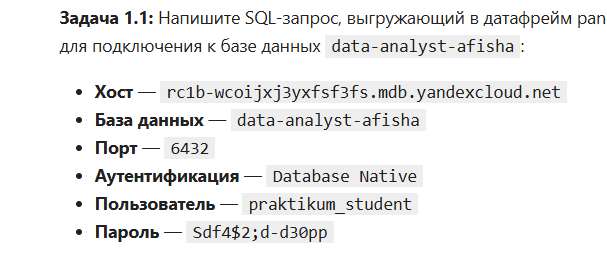
    
Можно еще добавить readme.md, где указать ключевые моменты проекта. Или зафиксировать цели и полученные выводы.